# Setup

 Import standard modules

In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.optimize import brentq
os.chdir('/home/chris/projects/tidal_flat_0d')

In [2]:
from src import features, models
from pyprojroot import here
root = here()
sys.path.append(str(root))
wdir = root / "data" / "interim"
minute = 60
hour = minute * 60
day = hour * 24
week = day * 7
month = day * 30
year = day * 365

Import project modules from src folder

In [5]:
tides = features.load_tide(wdir, "tides.feather")
tides = tides - (np.mean(tides) + 0.6)
vals = np.empty(0)
for i in range(0,2):
    vals = np.append(vals, tides.values + 0.005 * i)
ts = pd.Series(vals)
sub = pd.Series(tides.values)

In [41]:
from src import models2
tf = models2.TidalFlat(
    tide_ts=ts,
    land_elev_init=1.15,
    conc_bound=0.9,
    grain_diam=3.5e-5,
    grain_dens=2.65e3,
    bulk_dens=900,
    org_rate_yr=2e-4,
    comp_rate_yr=4e-3,
    sub_rate_yr=3e-3,
    slr_yr=0.005,
)
tf.run()

Progress: 100%|██████████| 730/730 [00:50<00:00, 14.33day/s]


In [37]:
tf

array([1.19746857, 1.19746857, 1.19746857, 1.19746857, 1.19746857,
       1.19746857, 1.19746857, 1.19746857, 1.19746857, 1.19746857,
       1.19746857, 1.19746857, 1.19746857, 1.19746857, 1.19746857,
       1.19746857, 1.19746857, 1.19746857, 1.19746857, 1.19746857,
       1.19746857, 1.19746857, 1.19746857, 1.19746857, 1.19746857,
       1.19746857, 1.19746857, 1.19746857, 1.19746858, 1.19746858,
       1.19746858, 1.19746858, 1.19746858, 1.19746858, 1.19746858,
       1.19746858, 1.19746858, 1.19746858, 1.19746858, 1.19746859,
       1.19746859, 1.19746859, 1.19746859, 1.19746859, 1.19746859,
       1.19746859, 1.1974686 , 1.1974686 , 1.1974686 , 1.1974686 ,
       1.1974686 , 1.19746861, 1.19746861, 1.19746861, 1.19746861,
       1.19746862, 1.19746862, 1.19746862, 1.19746863, 1.19746863,
       1.19746864, 1.19746864, 1.19746864, 1.19746865, 1.19746865,
       1.19746866, 1.19746866, 1.19746867, 1.19746868, 1.19746868,
       1.19746869, 1.1974687 , 1.1974687 , 1.19746871, 1.19746

In [42]:
z = np.empty(0)
t = np.empty(0)
for i in tf.inundations:
    t = np.append(t, i.pos_start)
    z = np.append(z, i.land_elev_init)
    t = np.append(t, i.pos_end)
    z = np.append(z, i.result.y[2][-1])

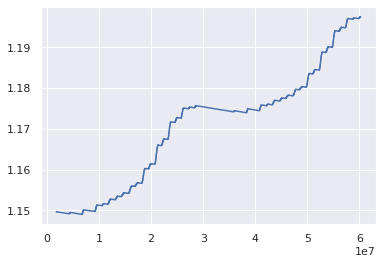

In [43]:
plt.plot(t, z)